In [1]:

# Sys imports
import json
import os
import sys
from tqdm import tqdm

os.environ["KERAS_BACKEND"] = "jax"

# Training API
import keras as keras
from keras import layers
import keras_nlp

# Data manipulation and exploration
import numpy as np
from scipy.stats import shapiro, kurtosis

# Data visualization
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# NLP
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import jax.numpy as jnp

# MLOps API
import mlflow
mlflow.set_tracking_uri('http://localhost:5000')


2024-03-21 18:35:22.943296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 18:35:22.943336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 18:35:22.944655: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 18:35:23.716353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# EDA

## Data loading
There are 72M titles and views in the data used.

In [2]:
# DATA LOADER 
def parse_jsonl_optimized(filepath, num_lines_to_import=None):
    titles = []
    view_counts = []
    with open(filepath, 'r', encoding='utf-8') as file:
        for i, line in enumerate(tqdm(file, desc="Processing")):
            # Check if the specified number of lines has been reached (if specified)
            if (num_lines_to_import is not None and i >= num_lines_to_import):
                break
            # Parse the current line
            data = json.loads(line)
            # Extract and store the title and view count
            titles.append(data['title'])
            view_counts.append(data['view_count'])
    return titles, view_counts

# Example usage: Import only the first 1000 lines from the file
file_path = '/mnt/datassd/train_data.jsonl'
num_lines_to_import = 7000000  # You can adjust this number as needed
titles, view_counts = parse_jsonl_optimized(file_path, num_lines_to_import)

Processing: 7000000it [00:12, 572149.30it/s]


## Create $Log_{10}(Data)$ and create tokenizer

When views are analyzed on their own, the MSE loss function does not make a lot of sense, there is a lot of variation in the data.

What's why we take $log_{10}$ to get the order of magnitude of the views ($10^x$).

In [3]:
y_view_count = np.where(np.log10(view_counts) == -np.inf, 0, np.log10(view_counts))

from transformers import AutoTokenizer
from concurrent.futures import ThreadPoolExecutor

# Load BERT tokanizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

/tmp/ipykernel_61990/2818422132.py:1: RuntimeWarning: divide by zero encountered in log10
  y_view_count = np.where(np.log10(view_counts) == -np.inf, 0, np.log10(view_counts))


Encoding all 70M datapoints takes ~45mins

In [4]:
""" SINGLE THREADED  """
encoded_inputs = [tokenizer.encode(title, add_special_tokens=True) for title in tqdm(titles, total=len(titles), desc="Encoding")]

Encoding: 100%|██████████| 7000000/7000000 [05:37<00:00, 20762.47it/s]


In [5]:
#""" SOMEWHAT MULTITHREADED """
#def encode_title(title):
#    return tokenizer.encode(title, add_special_tokens=True)
#with ThreadPoolExecutor() as executor:
#    encoded_inputs = list(tqdm(executor.map(encode_title, titles), total=len(titles), desc="Encoding"))

In the context of title engagement, UPPER CASED titles correlate with engagement, it is important to use a CASED tokenizer.

In [6]:
# Testing cased inputs in tokenization
titulos_raros = [r'IS THIS TOKEN Cased?']
print(tokenizer.tokenize(titulos_raros[0]))
tokenizer.encode(titulos_raros[0], add_special_tokens=True)

['IS', 'T', '##H', '##IS', 'TO', '##KE', '##N', 'Case', '##d', '?']


[101, 19432, 157, 3048, 6258, 16972, 22441, 2249, 9060, 1181, 136, 102]

## Data Normalization tests

First, let's see the distribution of view counts

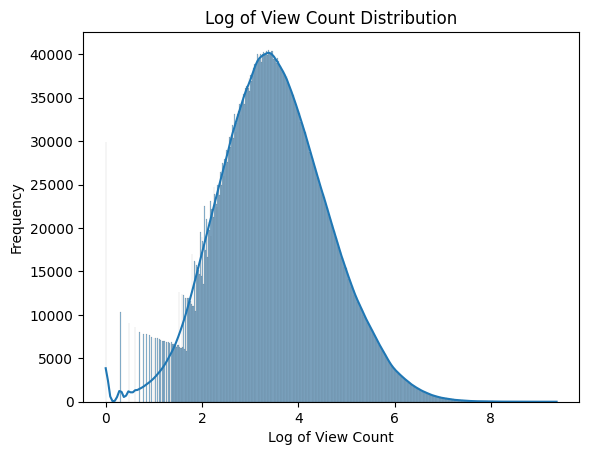

In [7]:
# See Y view count distribution
sns.histplot(y_view_count, kde=True)
plt.title("Log of View Count Distribution")
plt.xlabel("Log of View Count")
plt.ylabel("Frequency")
plt.show()

In [8]:
shapiro_test_stat, shapiro_p_value = shapiro(y_view_count)
kurtosis_value = kurtosis(y_view_count, fisher=True)

shapiro_test_stat, shapiro_p_value, kurtosis_value

/home/jay/.local/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9972044229507446, 0.0, 0.15062388827226236)

Now let's see the ditribution of lenghts of titles.

We need to have a cutoff at a certain token lenght. So let's visualize when it would be appropriate to cut titles off.

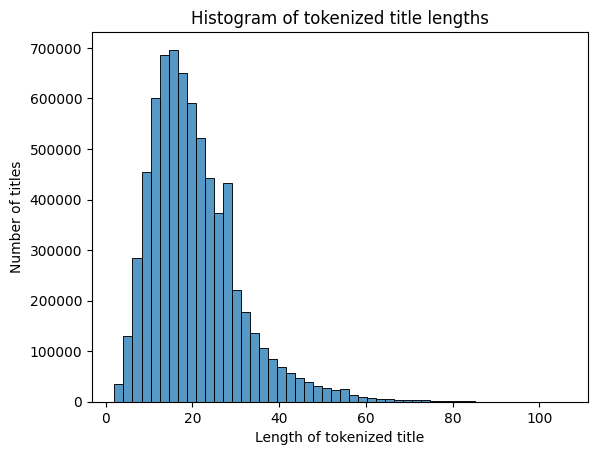

In [9]:
sns.histplot([len(encoded_input) for encoded_input in encoded_inputs], bins=50)
plt.title("Histogram of tokenized title lengths")
plt.xlabel("Length of tokenized title")
plt.ylabel("Number of titles")
plt.show()

Probably at 40 tokens, the cutoff would preserve most of the information. (Remember YouTube titles have a 100 char limit)

In [10]:
max_length = 40  # Ensure your data is adjusted accordingly

padded_inputs = pad_sequences(encoded_inputs, maxlen=max_length, padding='post', truncating='post')


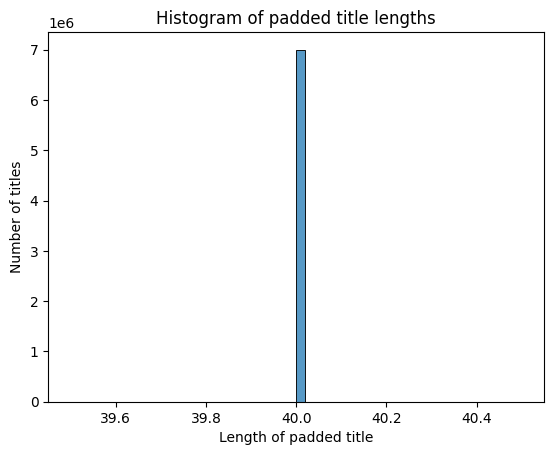

In [11]:
# Just making sure, all inputs are the same length of 40 
sns.histplot([len(padded_input) for padded_input in padded_inputs], bins=50)
plt.title("Histogram of padded title lengths")
plt.xlabel("Length of padded title")
plt.ylabel("Number of titles")
plt.show()

Some samples to see the PADs

In [12]:
sample = [tokenizer.decode(padded_input) for padded_input in padded_inputs[90:100]]
sample

['[CLS] Sigala - Brighter Days ft. Paul Janeway of St. Paul & The Broken Bones [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] Sigala - What You Waiting For ( Lyrics ) ft. Kylie Minogue [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] Sikdope - Lost In The Blue Feat. Nevve [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] Smiie - Fool ( Official Music Audio ) [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] Lauv - Superhero ( Moilatch Remix ) [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [13]:
X_t = jnp.array(padded_inputs)
Y_t = jnp.array(y_view_count)

vocab_size = 30522  # Adjusted to match BERT's vocabulary size for bert-base-cased
embedding_dim = 768  # Standard BERT-base embedding dimension
transformer_encoder_layers = 4  # Increase this for a larger model
num_heads = 12  # Increase this for a larger model
intermediate_dim = 3072  # Dimensionality of the encoder layers and the pooler layer
dropout_rate = 0.1  # Dropout rate for regularization

# Input layer
inputs = keras.Input(shape=(max_length,), dtype='int32')

# Embedding layer
embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=vocab_size, 
    sequence_length=max_length, 
    embedding_dim=embedding_dim,
)
x = embedding_layer(inputs)

# Transformer blocks
for _ in range(transformer_encoder_layers):
    encoder = keras_nlp.layers.TransformerEncoder(
        num_heads=num_heads,
        intermediate_dim=intermediate_dim,
        activation='relu',
        dropout=dropout_rate,
    )
    x = encoder(x)

# Pooling and output layers
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1, activation='linear')(x)  # Use linear activation for regression

# Model compilation
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Display the model's architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 40, 768)        │    23,471,616 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 40, 768)        │     7,087,872 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 40, 768)        │     7,087,872 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_2           │ (None, 40, 768)        │     7,087,872 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_3           │ (None, 40, 768)        │     7,087,872 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 768)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,020,225 (198.44 MB)

 Trainable params: 52,020,225 (198.44 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
class MlflowCallbackLogPerBatch(mlflow.keras_core.MLflowCallback):
    def on_batch_end(self, batch, logs=None):
        if self.log_every_n_steps is None or logs is None:
            return
        if (batch + 1) % self.log_every_n_steps == 0:
            self.metrics_logger.record_metrics(logs, self._log_step)
            self._log_step += self.log_every_n_steps


with mlflow.start_run() as run:
    model.fit(X_t, Y_t, batch_size=32, epochs=5, validation_split=0.2, callbacks= [MlflowCallbackLogPerBatch(run, log_every_epoch=False, log_every_n_steps=5)])
mlflow.end_run()

Using JAX backend.


Epoch 1/5
175000/175000 ━━━━━━━━━━━━━━━━━━━━ 6753s 39ms/step - loss: 1.3230 - mean_squared_error: 1.3230 - val_loss: 1.3588 - val_mean_squared_error: 1.3588
Epoch 2/5
175000/175000 ━━━━━━━━━━━━━━━━━━━━ 6759s 39ms/step - loss: 1.2933 - mean_squared_error: 1.2933 - val_loss: 1.3587 - val_mean_squared_error: 1.3587
Epoch 3/5
175000/175000 ━━━━━━━━━━━━━━━━━━━━ 6753s 38ms/step - loss: 1.2949 - mean_squared_error: 1.2949 - val_loss: 1.3605 - val_mean_squared_error: 1.3605
Epoch 4/5
175000/175000 ━━━━━━━━━━━━━━━━━━━━ 6608s 38ms/step - loss: 1.2931 - mean_squared_error: 1.2931 - val_loss: 1.3629 - val_mean_squared_error: 1.3629
Epoch 5/5
175000/175000 ━━━━━━━━━━━━━━━━━━━━ 6604s 38ms/step - loss: 1.2929 - mean_squared_error: 1.2929 - val_loss: 1.3671 - val_mean_squared_error: 1.3671


# Evaluation

In [15]:
# Load the eval dataset
eval_file_path = '/mnt/datassd/test_data.jsonl'
titles_eval, view_counts_eval = parse_jsonl_optimized(eval_file_path, num_lines_to_import*0.01)
encoded_evals = [tokenizer.encode(title_ev, add_special_tokens=True) for title_ev in tqdm(titles_eval, total=len(titles_eval), desc="Encoding")]
padded_evals = pad_sequences(encoded_evals, maxlen=max_length, padding='post', truncating='post')
view_evals = np.where(np.log10(view_counts_eval) == -np.inf, 0, np.log10(view_counts_eval))

Processing: 70000it [00:00, 446250.70it/s]
Encoding: 100%|██████████| 70000/70000 [00:03<00:00, 23005.12it/s]
/tmp/ipykernel_61990/812263401.py:6: RuntimeWarning: divide by zero encountered in log10
  view_evals = np.where(np.log10(view_counts_eval) == -np.inf, 0, np.log10(view_counts_eval))


In [ ]:
Y_e = jnp.array(view_evals)
X_e = jnp.array(padded_evals)

2188/2188 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step


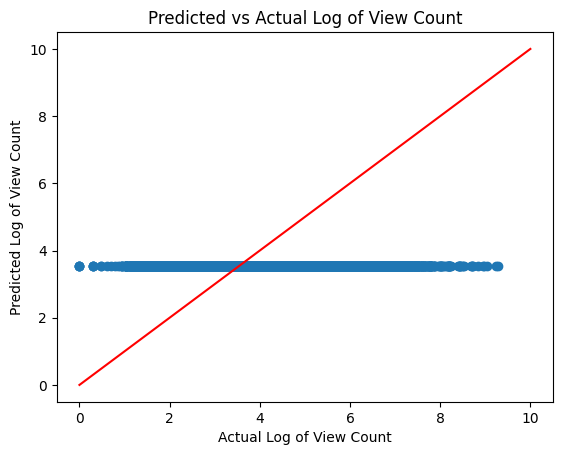

In [17]:
Y_pred = model.predict(X_e)

# Make scatter of predicted vs actual
plt.scatter(Y_e, Y_pred)
# Make a line
plt.plot([0, 10], [0, 10], color='red')
plt.title("Predicted vs Actual Log of View Count")
plt.xlabel("Actual Log of View Count")
plt.ylabel("Predicted Log of View Count")
plt.show()

In [18]:
Y_pred = Y_pred.flatten()
Y_pred

array([3.5347657, 3.5347657, 3.5347657, ..., 3.5347652, 3.5347652,
       3.5347657], dtype=float32)

In [19]:
# Arange titles by highest predicted view count
sorted_titles = [title for _, title in sorted(zip(Y_pred, titles_eval), reverse=True)]
sorted_titles[:100]

["🤯 Unfriended! This Narcissist Thinks He's Better Than Me?! My Most Recent Brush with a Narcissist",
 '🤢Narcissists Are Freaking Weird! 22 Disgusting Body Habits & Odd Stuff They Do at Home',
 '🤘 Female Drummers Worldwide ! Playing some Mind Blowing tunes and Solos',
 '🤑 EXPENSIVE Vs. CHEAP FOOD CHALLENGE 💵 WHICH ONE IS BETTER? 🤔',
 '🛰 Into the Galaxy 🚀- Virtual Surround Sound Experience',
 '🙏Zen Meditation Music: Soothing Music, Balance & Harmony, Relaxation, Spa Music, Yoga Music',
 '🙏Relaxing Zen Music + Soothing Water Sounds, Meditation Music, Yoga Music, Music for Spa & Massage',
 '🙊 AIUTOOOO 🙉 LOL Surprise Fuzzy Pets pelosa - Chiara Malfoy',
 '😻 Pusheen il Gatto 😻 apertura Blind Box e Big Peluche - Chiara Malfoy',
 '😳Should You ALWAYS Listen to Your Gut? How to Tell the Difference Between Fear and Your Intuition',
 '😱WORST RATED CLOTHING STORE IN MY CITY 🛍GOT A KYLIE JENNER LOOK',
 '😱BEST OF MISS UNIVERSE 2018👑REVIEW & REACTION CATRIONA GRAY PHILIPPINES + TOP 5🔝 Recap Highlights